<a href="https://colab.research.google.com/github/shreeya-la/audio-ml/blob/main/yamnet_(using_tutorial_and_folds).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Download ESC50

In [ ]:
#!pip install tensorflow --upgrade

In [ ]:
# !pip uninstall tensorflow
# !pip uninstall tensorflow-io

In [ ]:
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2024-10-02 18:15:37--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-10-02 18:15:37--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-10-02 18:15:37--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=

In [ ]:
!unzip -qq master.zip

In [ ]:
%cd ESC-50-master
# create a dataframe
esc50_data = pd.read_csv('meta/esc50.csv')
esc50_data.head()

/content/ESC-50-master


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A
46,1-15689-B-4.wav,1,4,frog,False,15689,B
49,1-16568-A-3.wav,1,3,cow,False,16568,A
64,1-17585-A-7.wav,1,7,insects,False,17585,A
69,1-17970-A-4.wav,1,4,frog,False,17970,A
70,1-18074-A-6.wav,1,6,hen,False,18074,A


In [ ]:
def preprocess_wav(filename, target_sr=16000):
    filename = 'audio/' + filename
    # Load the .wav file using librosa
    audio, sampling_rate = librosa.load(filename, sr=None)

    # Resample to target sample rate (16kHz)
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sr)

    # If audio has more than 1 channel, convert to mono
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    # Convert to float32 TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    return audio_tensor

In [ ]:
# @tf.function
# def load_wav_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     file_contents = tf.io.read_file(filename)
#     wav, sample_rate = tf.audio.decode_wav(
#           file_contents,
#           desired_channels=1)
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

# YAMNet

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_model_handle)

In [ ]:
# get a sample .wav file
sample_file = esc50_animals.iloc[0]['filename']
esc_single_waveform = preprocess_wav(sample_file)

# # plot and display
# _ = plt.plot(esc_single_waveform)
# display.Audio(esc_single_waveform, rate=16000)

In [ ]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [ ]:
# to find the top-scored class, take the maximum of the 521 aggregated scores.
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Silence


In [ ]:
# results = []

# # for each file in the esc50_animals
# for index, row in esc50_animals.iterrows():

#     #preprocess
#     filename = row['filename']
#     wav = preprocess_wav(filename)

#     #run yamnet
#     scores, embeddings, spectrogram = yamnet(wav)

#     # convert scores to numpy array and find the inferred class
#     scores_np = scores.numpy()
#     predicted = class_names[scores_np.mean(axis=0).argmax()]

#     # Store the result
#     results.append({
#         #'filename': filename,
#         'predicted class': predicted.lower(),
#         'true class': row['category']
#     })

# results_df = pd.DataFrame(results)

In [ ]:
# results_df.head(20)

NameError: name 'results_df' is not defined

# Sequential Model

In [ ]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [ ]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A


In [ ]:
# convert columns to numpy arrays
filenames = esc50_animals['filename']
targets = esc50_animals['target']
folds = esc50_animals['fold']

esc50 = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
esc50.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# def load_wav_for_map(filename, label, fold):
#     return preprocess_wav(filename), label, fold

# esc50 = esc50.map(load_wav_for_map)
# esc50.element_spec

In [ ]:
def load_wav_for_map(filename, label, fold):
    def _load_wav(filename):
        filename_str = filename.numpy().decode('utf-8')
        return preprocess_wav(filename_str)

    # wrap the python-based _load_wav function
    audio = tf.py_function(_load_wav, [filename], tf.float32)
    return audio, label, fold

esc50 = esc50.map(load_wav_for_map)
esc50.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  # run YAMNet to extract embedding from the wav data
  scores, embeddings, spectrogram = yamnet(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
esc50 = esc50.map(extract_embedding).unbatch()
esc50.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# clips from the same original source should always be in the same fold
cached_ds = esc50.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

In [ ]:
# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_classes = len(animals)

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)
], name='my_model')

#my_model.summary()

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=40,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9153 - loss: 0.2475 - val_accuracy: 0.7613 - val_loss: 1.1231
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9196 - loss: 0.2406 - val_accuracy: 0.7575 - val_loss: 1.1605
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9237 - loss: 0.2310 - val_accuracy: 0.7588 - val_loss: 1.1774
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9278 - loss: 0.2183 - val_accuracy: 0.7525 - val_loss: 1.2030
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9119 - loss: 0.2420 - val_accuracy: 0.7513 - val_loss: 1.1877
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9254 - loss: 0.2117 - val_accuracy: 0.7475 - val_loss: 1.1928
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9139 - loss: 0.2368 - val_accuracy: 0.7600 - val_loss: 1.2046
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9148 - loss: 0.2271 - val_accuracy: 0.7550 - v

In [ ]:
# evaluate the model
loss, accuracy = my_model.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5677 - loss: 2.5685
Test accuracy: 0.6750


In [ ]:
# with early stopping
# 20 epochs: 0.8188 (stopped at 13)
# 40 epochs: 0.6750 (stopped at 8)

In [ ]:
# get the true labels and predicted labels
true_labels = []
predicted_labels = []

for embedding, label in test_ds:
    true_labels.append(label.numpy())  # true label
    predictions = my_model.predict(embedding)  #  model predictions
    predicted_labels.append(np.argmax(predictions, axis=1))  # convert predictions to class labels

# convert lists to arrays
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


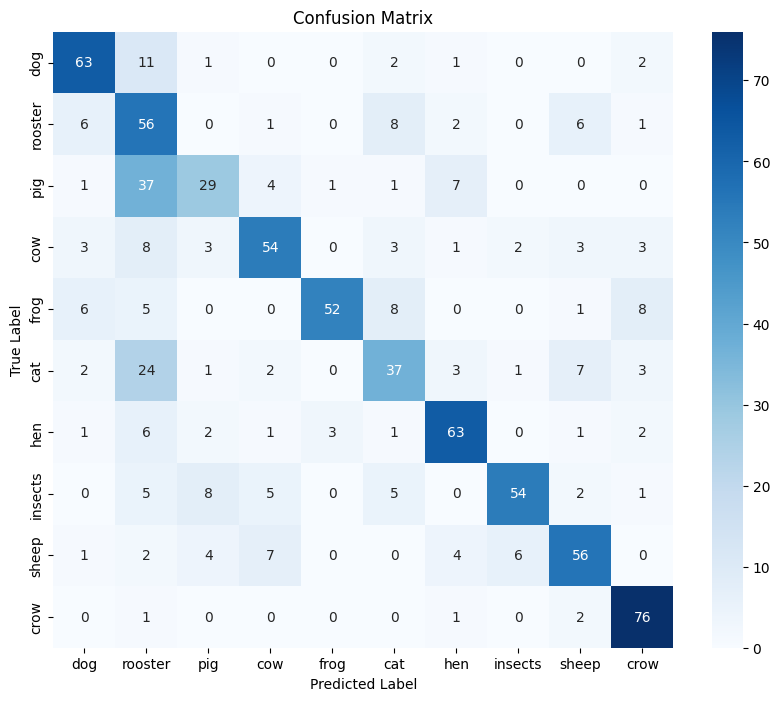

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=animals, yticklabels=animals)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
result = my_model(embeddings).numpy()

inferred_class = animals[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: dog


# One Function

In [ ]:
# one function to preprocess and predict

def full_yamnet(filename):
    # preprocess the .wav file
    esc_waveform = preprocess_wav(filename)

    # run YAMNet and get the embedding
    scores, embeddings, spectrogram = yamnet(esc_waveform)

    # use the full classification model
    predictions =  my_model(embeddings).numpy()

    # Get the predicted class label
    predicted_label = animals[result.mean(axis=0).argmax()]

    print(f"Predicted Category: {predicted_label}")

    # get the true category
    category = esc50_animals[esc50_animals['filename'] == filename]['category'].values[0]
    print(f"True Category: {category}")

In [ ]:
full_yamnet(esc50_animals.iloc[20]['filename'])

Predicted Category: dog
True Category: pig


In [ ]:
# and 32 per batch
def get_size(dataset):
    return sum(1 for _ in dataset)

train_size = get_size(train_ds)
val_size = get_size(val_ds)
test_size = get_size(test_ds)

print(f"training: {train_size}")
print(f"validation: {val_size}")
print(f"test: {test_size}")

training: 75
validation: 25
test: 25
